# Problem Definition (High-level)

Develop a real-time supply allocation mechanism to match the demand over the entire service area at any given point of time. An optimal allocation mechanism ensures that every riders gets a ride and the waiting time for drivers to get a ride is minimized under the assumption that there is enough supply (drivers) to satisfy the total demand at any given point.

**Note: Although I write "we" as the pronoun in this document, it is just a style that I prefer.**

# Solution Proposal

In the data exploration notebook, we saw that one of the salient features of the dataset is the temporal and spatial correlation of demand. We propose to leverage this correlation to develop a simple linear demand forecasting model. To do so, we first discretize time and space in suitable units:

- **Spatial discretization**: Since no information about the spatial divisions is provided, we divide the operational area (here city of Talinn) into "zones" using a 10 $\times$ 10 grid. In our solution, we use all the data available to define this grid such that the average demand over the 4 weeks is same in each individual grid (splitting latitudes and longitudes using quantile cuts).

- **Temporal discretization**: To reduce noise in forecasts, we aggregate the total revenue within each zone (as described above) over a 15 minutes interval and transform the data into a time series (again for each zone separately).

**Demand proxy**: While demand in a ride hailing context could refer to the *number* of potential rides, we use the total expected ride value as a proxy for the demand, since it likely better aligned with key business metrics like profit and revenue.

In the data exploration part, we already noticed that demand is usually very well correlated over region and time. In our solution we use these correlations over space and time in a **Lasso linear regression model** using the `darts` library. This model is essentially an autoregressive model (to capture **temporal correlations**) with additional covariates capturing past demand of other zones (to capture **spatial correlations**). Below we show the main specification of this model:
```
model = RegressionModel(
    model=Lasso(alpha=5),
    lags=[-1, -2, -4, -16, -96],
    lags_past_covariates=[-1, -2, -4, -16, -96],
    output_chunk_length=1,
)
```
`lags=[-1, -2, -4, -16, -96]` refers to the lags in the time series data that are used for generating predictions. Recall that our time series granularity is 15 minutes Hence -1 refers to the demand observed in the previous 15 minutes slot, -2 the demand in the slot before and so on. In addition to time lags, we also use the (past) time series of all the other zones. `lags_past_covariates` captures the lags in this time series. Although we have a lot of predictors (features) in this model, the Lasso regressor ensures we only use the most relevant ones.

**Feature Processing**: Apart from features related to time and geographical location, we use two derived features based on the datetime that are important to capture the intra-week and intra-day seasonality in the data (as seen in data exploration):
- day-of-week
- hour-of-day

These transformed from numeric values [0, n-1] to a tuple of values using a cyclic encoding approach.

## Key Features

- **Designed for real-time operation**: This approach models the target variable (demand in a given zone) as a function of the demand in the recent past time intervals in the same zone *and* all other zones. Any unexpected spike in demand in a zone would immediately lead to corrections in the subsequent time intervals for that and other correlated zones.

# Model Validation

The model parameters are validated using a backtesting approach. Starting from 1300 time steps into the training data, we train the model on all available past data (backtest training data) and test it on the next time slot immediately following that. This process is repeated 43 times gradually increasing the dataset used for training

| 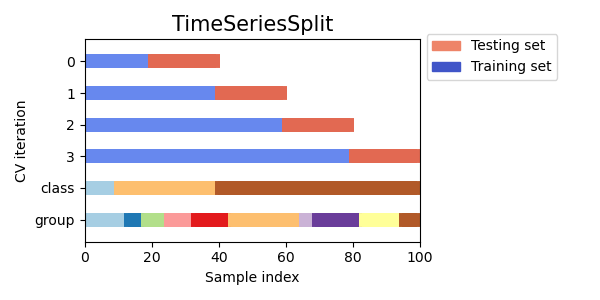 | 
|:--:| 
| *Illustration of backtesting ([source](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split))* |

**Note:** In the current implementation, we'd need to retrain the model after every 15 mins. Based on specific requirements/constraints, we could easily reconfigure the presented model to output predictions for several time slots in the future.

## Miscellaneous Points

### Some core assumptions in the proposal

- The demand patterns observed on a given day at a particular time (alternatively the amount of money spent) are similar to the demand patterns observed in the past. The solution proposed here in fact only needs the relative order of the demands in different zones to remain constant. The absolute values have no impact.
<br><br>
- In the proposed baseline solution **we do not account for the existence of other drivers**. To improve the solution further, we could use the co-ordinates of other active drivers in the region to reweight the demand in the zones. Without this data, several drivers might be guided towards the same zone creating an over-supply problem.
<br><br>
- I have used 10 buckets for quantile splitting for both latitude and longitude just to demonstrate the approach. An appropriate value for these buckets should ideally be inferred using backtesting on past data.

### Additional data that would be useful 

- Number of drivers in operation at any given point in time and their locations in the training data. We do not know if we were able to cover the entire demand or not due to insufficient number of drivers.
- Information about the city operational zones. In this proposal, we are using an arbitrary grid. Information about meaningful zones within the city would be very helpful.
- Weather information

**Deployment and experimentation aspects are covered at the end**

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import Lasso

from datetime import datetime
from darts.timeseries import TimeSeries, concatenate
from darts.models import LinearRegressionModel, RegressionModel

import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce


# helper functions
def stack(dfs):
    return reduce(lambda a, b: a.stack(b), dfs)

def string_to_date(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d").date()

def get_sk_date(date):
    """Get date as integer in the form of yyyymmdd"""
    return date.year * 10000 + date.month * 100 + date.day

def cyclic_encoding(x, base=6.0):
    normalized_x = float(x)/base

    x = (np.sin(2 * np.pi * normalized_x) + 1) / 2.0
    y = (np.cos(2 * np.pi * normalized_x) + 1) / 2.0
    return x, y

In [2]:
week_boundaries = ['2022-03-01', '2022-03-08', '2022-03-15', '2022-03-22', '2022-03-29']
bins = [*map(lambda x: get_sk_date(string_to_date(x)), week_boundaries)]

df = pd.read_csv('robotex5.csv')

# extract date-time attributes
df['start_time'] = pd.to_datetime(df.start_time)
df['start_hour'] = df.start_time.dt.hour
df['start_min'] = df.start_time.dt.minute
df['start_dayofweek'] = df.start_time.dt.dayofweek
df['sk_start_time'] = df.start_time.apply(get_sk_date)
df['week_num'] = pd.cut(df.sk_start_time, bins=bins, labels=range(4), include_lowest=True)

df = df.loc[df.ride_value < 6]

# divide the latitudes and longitudes into 10 equal intervals based on total expected demand.
decile_buckets = np.linspace(0, 1, 11)
df['lat_bin'] = pd.qcut(df.start_lat, decile_buckets, labels=range(10))
df['lng_bin'] = pd.qcut(df.start_lng, decile_buckets, labels=range(10))


df['hour_quarter'] = pd.cut(df.start_min, bins=range(0, 61, 15), labels=range(4), include_lowest=True)
df = df.drop(columns=['start_min', 'sk_start_time'])

df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_hour,start_dayofweek,week_num,lat_bin,lng_bin,hour_quarter
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,15,6,0,1,1,0
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,11,3,1,8,7,0
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,14,6,0,6,5,1
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,9,3,0,1,0,0
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,0,6,0,5,6,0


## Example of space discretization

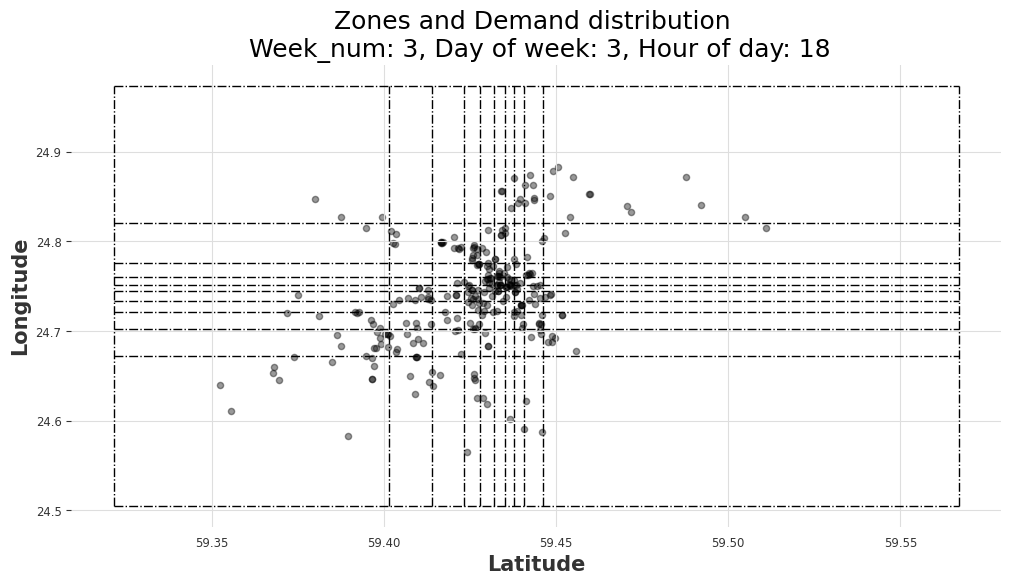

In [3]:
# randomly chosen time parameters
hour_of_day = 18
day_of_week = 3
week_num = 3
hour_quarter = 0


# create demand zones using complete data
buckets = np.linspace(0, 1, 11)

lat_buckets = df.start_lat.quantile(q=buckets).values
lng_buckets = df.start_lng.quantile(q=buckets).values

# This is the dataset we will use to make recommendations
train_data = (
    df
    .loc[
        (df.start_hour == hour_of_day) \
        & (df.start_dayofweek == day_of_week) \
        & (df.week_num == week_num) \
        & (df.hour_quarter == hour_quarter)].copy()
)

fig, ax = plt.subplots(figsize=(12, 6))

train_data.plot.scatter(x='start_lat', y='start_lng', ax=ax, alpha=0.4)
ax.grid(True)

plt.vlines(lat_buckets, ymin=lng_buckets[0], ymax=lng_buckets[-1], linestyles='dashdot', linewidth=1)
plt.hlines(lng_buckets, xmin=lat_buckets[0], xmax=lat_buckets[-1], linestyles='dashdot', linewidth=1)

ax.set_xlabel('Latitude', fontsize=15)
ax.set_ylabel('Longitude', fontsize=15)
ax.set_title(f'Zones and Demand distribution \n Week_num: {week_num}, Day of week: {day_of_week}, Hour of day: {hour_of_day}', fontsize=18)
plt.show()

## Transforming Pandas DataFrame into Darts TimeSeries

In [4]:
ts_df = (
    df
    .groupby(
        ["lat_bin", "lng_bin", "week_num", "start_dayofweek", "start_hour", "hour_quarter"], 
        observed=False)
    .agg({'ride_value': 'sum'})  # sum of ride value is proxy for demand
    .reset_index()
)

time_index = (
    df
    .groupby(["week_num", "start_dayofweek", "start_hour", "hour_quarter"], observed=False)
    .size()
    .reset_index()
    .reset_index()
    .drop(columns=[0])
)
time_index.columns = ["time_col", "week_num", "start_dayofweek", "start_hour", "hour_quarter"]

ts_df.head()

,lat_bin,lng_bin,week_num,start_dayofweek,start_hour,hour_quarter,ride_value
0,0,0,0,0,0,0,12.625195
1,0,0,0,0,0,1,12.521336
2,0,0,0,0,0,2,10.869749
3,0,0,0,0,0,3,13.631914
4,0,0,0,0,1,0,17.458341


### Cyclical encoding of day-of-week and hour-of-day

In [5]:
# cyclical encoding of dayofweek feature
dayofweek_encoding = time_index['start_dayofweek'].apply(cyclic_encoding)

time_index['start_dayofweek_x'] = dayofweek_encoding.apply(lambda x: x[0])
time_index['start_dayofweek_y'] = dayofweek_encoding.apply(lambda x: x[1])


# cyclical encoding of start_hour feature
hour_encoding = time_index['start_hour'].apply(lambda x: cyclic_encoding(x, base=23.0))

time_index['start_hour_x'] = hour_encoding.apply(lambda x: x[0])
time_index['start_hour_y'] = hour_encoding.apply(lambda x: x[1])

complete_ts = ts_df.merge(time_index).set_index("time_col")
complete_ts

,lat_bin,lng_bin,week_num,start_dayofweek,start_hour,hour_quarter,ride_value,start_dayofweek_x,start_dayofweek_y,start_hour_x,start_hour_y
time_col,,,,,,,,,,,
0,0,0,0,0,0,0,12.625195,0.5,1.0,0.500000,1.000000
1,0,0,0,0,0,1,12.521336,0.5,1.0,0.500000,1.000000
2,0,0,0,0,0,2,10.869749,0.5,1.0,0.500000,1.000000
3,0,0,0,0,0,3,13.631914,0.5,1.0,0.500000,1.000000
4,0,0,0,0,1,0,17.458341,0.5,1.0,0.634898,0.981459
...,...,...,...,...,...,...,...,...,...,...,...
2683,9,9,3,6,22,3,17.158206,0.5,1.0,0.365102,0.981459
2684,9,9,3,6,23,0,43.257799,0.5,1.0,0.500000,1.000000
2685,9,9,3,6,23,1,37.080671,0.5,1.0,0.500000,1.000000


### Combine time series of all zones in a list

In [6]:
covariates_dayofweek = TimeSeries.from_dataframe(time_index[['start_dayofweek_x', 'start_dayofweek_y']])
covariates_hour = TimeSeries.from_dataframe(time_index[['start_hour_x', 'start_hour_y']])

time_series_list = (
    TimeSeries.from_group_dataframe(
        complete_ts, 
        ["lat_bin", "lng_bin"], # one time series for each combination of lat and lng bin
        time_col=None, # use index as time column
        drop_group_cols=["lat_bin", "lng_bin"],
        value_cols=["ride_value"])
)

# creating one time series with 100 components
multivariate_ts = concatenate(time_series_list, axis=1)

/Users/paresh.nakhe/.pyenv/versions/venv_my_projects/lib/python3.11/site-packages/darts/timeseries.py:873: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(group_cols[0] if len(group_cols) == 1 else group_cols)


## Model Training and Validation

In [8]:
model = RegressionModel(
    model=Lasso(alpha=5),
    lags=[-1, -2, -4, -16, -96],
    lags_past_covariates=[-1, -2, -4, -16, -96],
    output_chunk_length=4, # predict demand for the next 4 (15 min) blocks.
)


# Backtest on different lengths of training data
for training_len in range(1340, 2688, 16):
    past_covariates_list = list()
    target_list = list()
    
    for i, ts in enumerate(time_series_list):
        target_list.append(ts[:training_len]['ride_value']) # target time series
        
        other_zones_ts_cov = time_series_list[:i]+time_series_list[i+1:]
        time_covs = [covariates_dayofweek, covariates_hour]
    
        clipped_series = [series[:training_len] for series in other_zones_ts_cov+time_covs]
        past_covariates_list.append(stack(clipped_series))
    
    
    model.fit(target_list, past_covariates=past_covariates_list)
    raw_predictions = model.predict(1, series=target_list, past_covariates=past_covariates_list)
    predictions = np.array([*map(lambda x: x.values().flatten()[0], raw_predictions)])

    true_dmd = multivariate_ts[training_len].values().flatten()
    print(f"Error: backtesting {mean_absolute_error(predictions, true_dmd)}")

Error: backtesting 2.2761597393702417


## Concrete example of demand prediction

In this section, we compute the predictions for a specific time slot

In [9]:
past_covariates_list = list()
target_list = list()
training_len = 2376

# create target time series and covariate data for training
for i, ts in enumerate(time_series_list):
    # create training data for each zone
    target_list.append(ts[:training_len]['ride_value']) # target time series
    
    other_zones_ts_cov = time_series_list[:i]+time_series_list[i+1:]
    time_covs = [covariates_dayofweek, covariates_hour]

    clipped_series = [series[:training_len] for series in other_zones_ts_cov+time_covs]
    past_covariates_list.append(stack(clipped_series))


# model fitting
model.fit(target_list, past_covariates=past_covariates_list)

raw_predictions = (
    model
    .predict(1, series=target_list, past_covariates=past_covariates_list)
)

In [10]:
# create a pandas dataframe with predictions for each zone
predictions = np.array([*map(lambda x: x.values().flatten()[0], raw_predictions)])
predictions_df = pd.DataFrame(predictions.reshape(10, 10))

predictions_df.columns = [f"lng_{i}" for i in range(10)]
predictions_df.index = [f"lat_{i}" for i in range(10)]

predictions_df = predictions_df.sort_index(ascending=False)

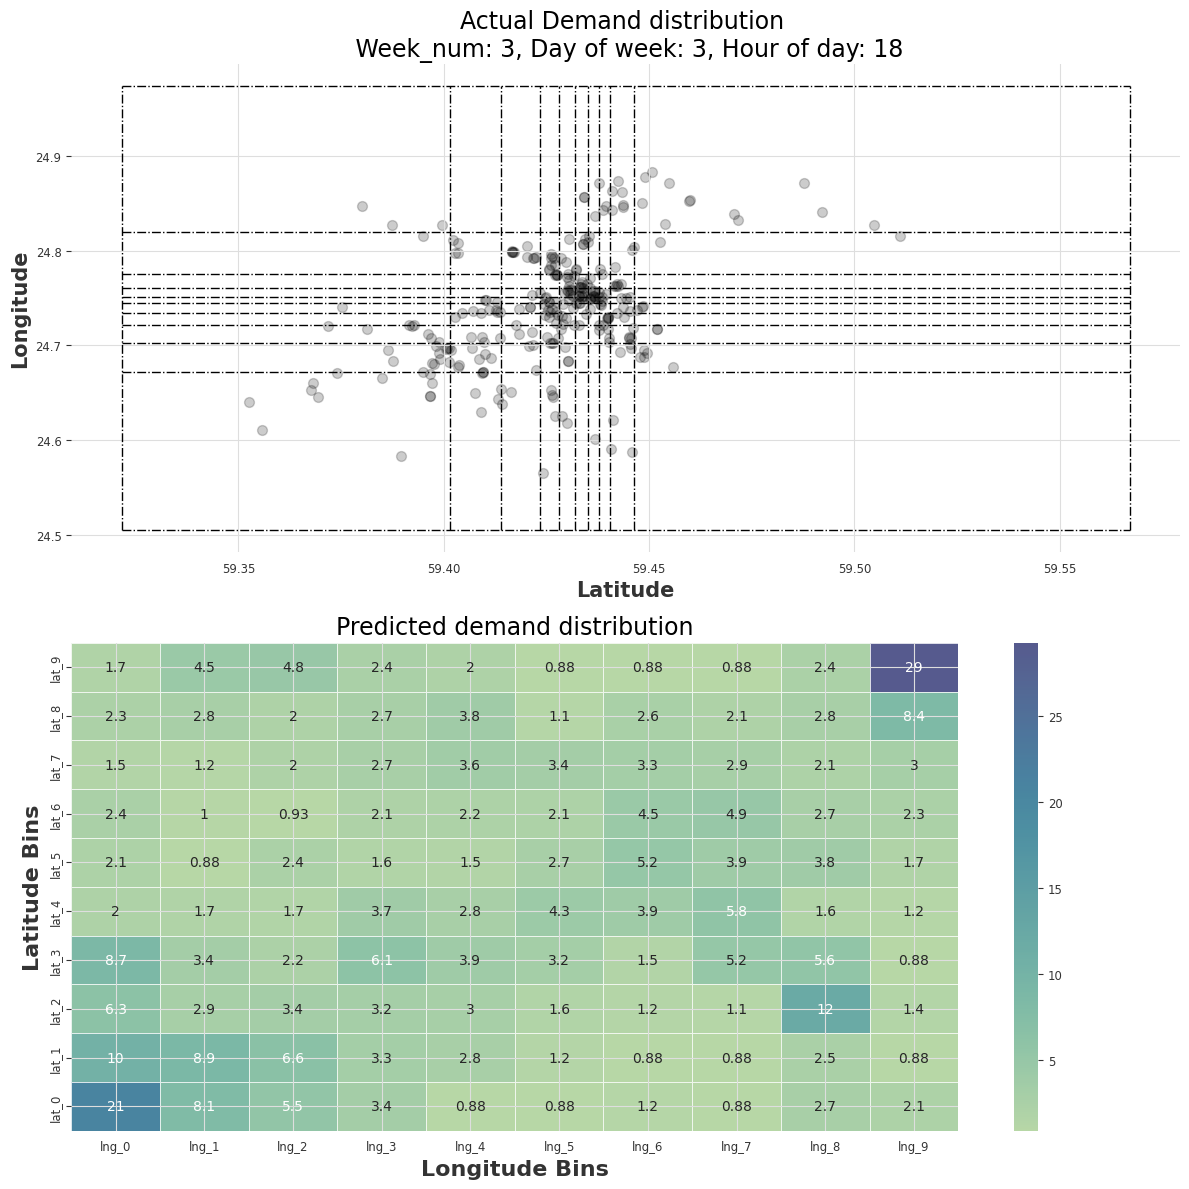

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

#####
train_data.plot.scatter(x='start_lat', y='start_lng', ax=ax[0], s=50, alpha=0.2)
ax[0].grid(True)

ax[0].vlines(lat_buckets, ymin=lng_buckets[0], ymax=lng_buckets[-1], linestyles='dashdot', linewidth=1)
ax[0].hlines(lng_buckets, xmin=lat_buckets[0], xmax=lat_buckets[-1], linestyles='dashdot', linewidth=1)

ax[0].set_xlabel('Latitude', fontsize=15)
ax[0].set_ylabel('Longitude', fontsize=15)
ax[0].set_title(f'Actual Demand distribution \n Week_num: {week_num}, Day of week: {day_of_week}, Hour of day: {hour_of_day}', fontsize=17)
#####

sns.heatmap(predictions_df, annot=True, linewidth=.5, ax=ax[1], alpha=0.8, cmap="crest")
ax[1].set_xlabel('Longitude Bins', fontsize=16)
ax[1].set_ylabel('Latitude Bins', fontsize=16)
ax[1].set_title(f"Predicted demand distribution", fontsize=17)

plt.tight_layout()
plt.show()

## Communicating Model Recommendations to Drivers

I'd use the predicted distribution above to guide the driver. For example, suppose the driver is in the zone with the red spot.

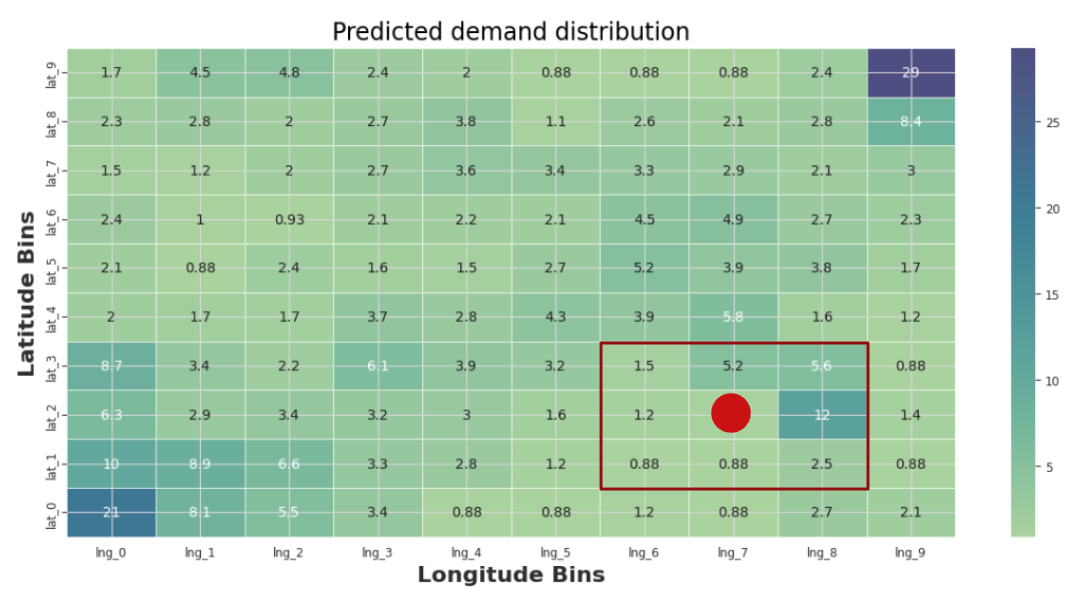

The first set of recommendations are drawn from a pool of immediate neighbouring zones. In this particular example, the zone with expected demand of 12 (for the actual communication, I'd remove the numbers relying instead on the color-coding). If the driver "zooms-out", the expected demand of other zones will then be shown.

## Model Deployment

For the deployment of the model I'd focus on the following steps:

- **Containerization**: Package the serialized model and its dependencies into a Docker container.
- **Infrastructure set-up**: This step involves choosing a platform for deployment. The Sagemaker service by AWS, for example, can be used for real-time usage.
- **Deploy the container and expose an API**: The API is needed to allow external applications (like the apps used by drivers) to interact with the model.
- **Monitoring setup**: This includes monitoring the model performance, data checks and latency.

Additional considerations include managing model versions to facilitate rollback and retraining the model at a chosen cadence.

## Design of the experiment to validate the solution

### Test Hypothesis

The goal of creating the recommendation system for drivers is a more efficient matching of drivers and riders (customers). The success of a candidate solution can be therefore be measured using the following three key metrics:

1. **Idle time between rides** - This metric measures the "idle duration" for each ride. We expect to lower this metric for the set of drivers that receive the recommendations. 
2. **Distance to rider (alternatively waiting time for rider)** - This metric measure the distance / time to reach the pick up point of rider after recieving the pick-up request. If the recommendations works as intended, this metric should be lower compared to control group.
3. **Total earnings (alternatively earnings per hour)** - This metric although correlated with the two above, is the **key business metric**. Improving the efficiency of supply allocation should result in an improvement in the total earnings.


To test the validity of the solution we can select a random group of (say) 50% of the drivers in the treatment group who receive these model recommendations. The remaining drivers (control group) continue to function as before. After a 1-2 weeks, analyze the test metrics to identify the effect.